In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pmdarima as pm
from math import sqrt


In [16]:
df=pd.read_csv('C:/Abdelouaheb/perso/Ph/time_series_analysis/data/cpu_index_usa.csv', index_col='Year', parse_dates=True)

In [17]:
# Understanding the data for time based train-test split
print(f'Start Date: {df.index.min()}')
print(f'End Date: {df.index.max()}')
print(f'Total Days: {len(df)}')

Start Date: 1913-01-01 00:00:00
End Date: 2023-01-01 00:00:00
Total Days: 111


In [18]:
# Check for missing values in the entire DataFrame
missing_values = df.isnull().sum()

# Display the count of missing values for each column
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
cpu    0
dtype: int64


In [19]:
df.head(2)

,cpu
Year,
1913-01-01,0.0
1914-01-01,1.0


In [20]:
df.tail(2)

,cpu
Year,
2022-01-01,8.0
2023-01-01,4.1


In [21]:
df.columns = ['cpu']
df.tail()

,cpu
Year,
2019-01-01,1.8
2020-01-01,1.2
2021-01-01,4.7
2022-01-01,8.0
2023-01-01,4.1


In [22]:
# Time based train-test splitting
test = df.loc['2000-01-01':]
train = df.loc[:'2000-01-01']

In [23]:
print(train.shape)
print("-"*50)
print(test.shape)

(88, 1)
--------------------------------------------------
(24, 1)


## ARIMA Model

<Figure size 432x288 with 0 Axes>

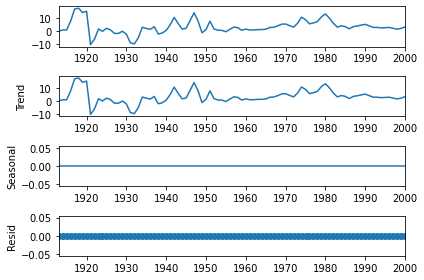

In [24]:
result = seasonal_decompose(train)

fig = plt.figure()  
fig = result.plot()
plt.show()

### Stationarity Test The Augmented Dickey-Fuller (ADF)

In [26]:
result=adfuller(train.cpu.dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')


ADF Statistics:-3.925544737491269
p-value:0.0018546911482577159


ADF test. Here are the two hypotheses:

Null Hypothesis (H0): The null hypothesis assumes the presence of a unit root in the time series data, indicating that the data is non-stationary. 

Alternative Hypothesis (H1): The alternative hypothesis is the complement to the null hypothesis. It assumes the absence of a unit root, indicating that the data is stationary. 

In our case we can not reject H0 becasue p-value:0.19987116175608627 > 0.05

### Differentiation  

In [28]:
result=adfuller(train.cpu.diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')


ADF Statistics:-6.9865733083977695
p-value:7.940503047364034e-10


c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


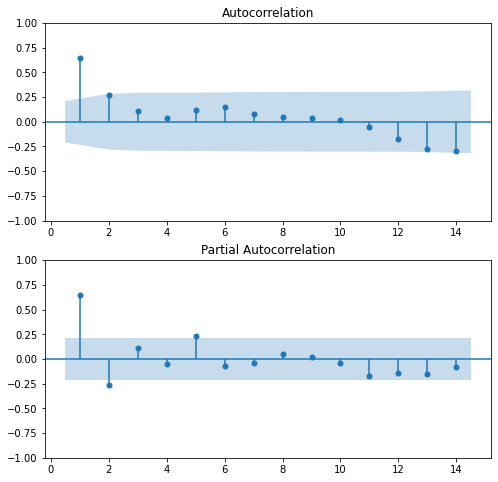

In [27]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(train,lags=14, zero=False, ax=ax1)
plot_pacf(train,lags=14, zero=False, ax=ax2)
plt.show()

### Choose model parameters ARIMA

In [28]:
results_arima=pm.auto_arima(train, d=0, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=False, m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (6) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=497.962, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=572.272, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=500.741, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=512.478, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=497.808, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=500.025, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=499.680, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=496.563, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=505.570, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=498.505, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=499.995, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=492.656, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=492.733, Time

### Fit ARIMA model

In [29]:
model_arima=SARIMAX(train,order=(1,0,1))
results_arima=model_arima.fit()

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [30]:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    cpu   No. Observations:                   88
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -245.981
Date:                Thu, 08 Feb 2024   AIC                            497.962
Time:                        15:34:04   BIC                            505.394
Sample:                    01-01-1913   HQIC                           500.956
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5802      0.111      5.204      0.000       0.362       0.799
ma.L1          0.3908      0.110      3.568      0.000       0.176       0.606
sigma2        15.5087      1.471     10.543      0.000      12.626      18.392
===================================================================================
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):               767.25
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                            -2.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Log Likelihood: The log-likelihood is a measure of how well a statistical model fits a set of observations. In this case, the log-likelihood value is -1121.131. A higher log-likelihood value indicates a better fit between the model and the data. In other words, the closer this value is to zero or a higher positive value, the better the model's fit.

AIC (Akaike Information Criterion): AIC is a measure of the relative quality of a statistical model for a given set of data. It balances the goodness of fit with the complexity of the model, penalizing models that are too complex. Lower AIC values indicate better models, with the lowest AIC suggesting the best trade-off between goodness of fit and model complexity. In this case, the AIC value is 2250.261.

BIC (Bayesian Information Criterion): BIC is similar to AIC but places a stronger penalty on models with more parameters. Like AIC, lower BIC values indicate better models, with the lowest BIC representing the best balance between model fit and complexity. The BIC value provided is 2265.883.

HQIC (Hannan-Quinn Information Criterion): HQIC is another criterion for model selection, similar to AIC and BIC. It also considers the model's goodness of fit and complexity but provides a different balance. As with AIC and BIC, lower HQIC values indicate better models, with the lowest HQIC suggesting the best model. The HQIC value given is 2256.468.

ma.L1 (Moving Average Lag 1):

Coefficient: 0.1547
Interpretation: For each unit increase in the error term at lag 1, we expect the current observation of electric production to increase by approximately 0.1547 units, holding other variables constant.
Significance: The coefficient is statistically significant (p < 0.001), indicating that the effect of the error term at lag 1 on the current observation is unlikely to be due to random chance.

ma.L2 (Moving Average Lag 2):

Coefficient: -0.4562
Interpretation: For each unit increase in the error term at lag 2, we expect the current observation of electric production to decrease by approximately 0.4562 units, holding other variables constant.
Significance: The coefficient is statistically significant (p < 0.001), suggesting that the effect of the error term at lag 2 on the current observation is unlikely to be due to random chance.

ma.L3 (Moving Average Lag 3):

Coefficient: -0.5491
Interpretation: For each unit increase in the error term at lag 3, we expect the current observation of electric production to decrease by approximately 0.5491 units, holding other variables constant.
Significance: The coefficient is statistically significant (p < 0.001), indicating that the effect of the error term at lag 3 on the current observation is unlikely to be due to random chance.

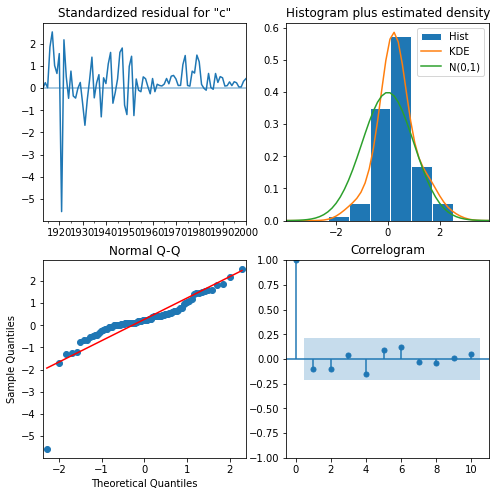

In [31]:
# Create the 4 diagostics plots
results_arima.plot_diagnostics(figsize=(8,8))
plt.show()

### Prediction using ARIMA

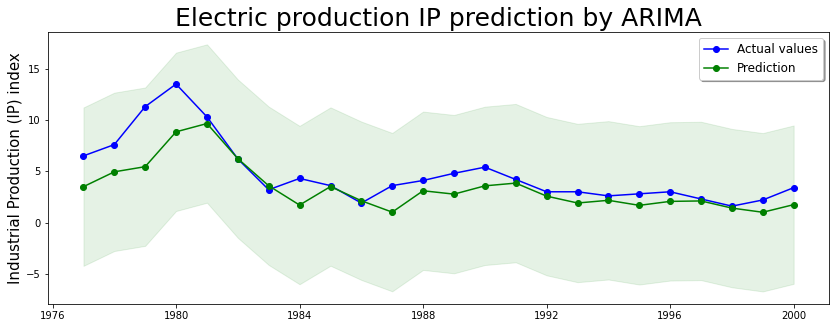

In [32]:
prediction_arima = results_arima.get_prediction(start=-24)
mean_prediction_arima=prediction_arima.predicted_mean
mean_prediction = mean_prediction_arima.rename("prediction")
confi_int_p_arima=prediction_arima.conf_int()
lower_limits_p_arima=confi_int_p_arima.iloc[:,0]
upper_limits_p_arima=confi_int_p_arima.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP prediction by ARIMA", fontsize=25)

plt.plot(train[-24:].index,train[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction_arima[-24:].index, mean_prediction_arima[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction_arima[-24:].index, lower_limits_p_arima, upper_limits_p_arima, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

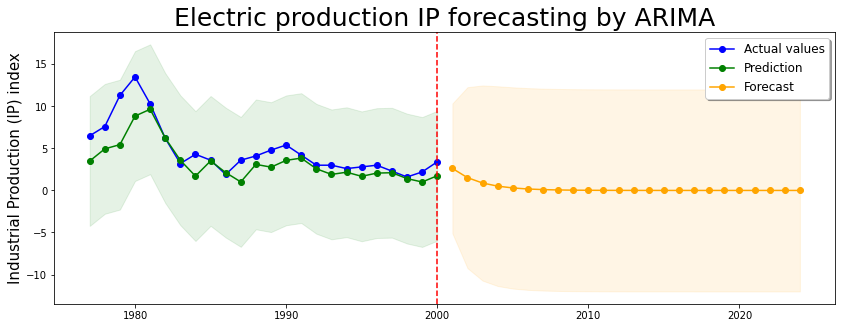

In [33]:
df_pred=train.iloc[-24:]
# Make ARIMA forecast of next 10 values
forecast_arima = results_arima.get_forecast(steps=24)
mean_forecast_arima=forecast_arima.predicted_mean
mean_forecast_arima = mean_forecast_arima.rename("prediction")
confi_int_f_arima=forecast_arima.conf_int()
lower_limits_f_arima=confi_int_f_arima.iloc[:,0]
upper_limits_f_arima=confi_int_f_arima.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by ARIMA", fontsize=25)

plt.plot(train[-24:].index,train[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p_arima, upper_limits_p_arima, alpha=0.1, color="green")

plt.plot(mean_forecast_arima[-24:].index,mean_forecast_arima[-24:].values, label='Forecast', color="orange", marker="o")
plt.fill_between(mean_forecast_arima[-24:].index, lower_limits_f_arima, upper_limits_f_arima, alpha=0.1, color="orange")

plt.axvline(df_pred.iloc[-24:].index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [34]:
df_arima = pd.concat([mean_prediction_arima, mean_forecast_arima])

In [78]:
f= pd.read_excel("C:/Users/ASUS TUF/Downloads/cpuu.xlsx")
panel_data = pd.melt(f, id_vars='Year', var_name='Region', value_name='Percentage')

panel_data.to_excel("C:/Users/ASUS TUF/Downloads/cpuu_sar.xlsx")

### SARIMA Model

In [75]:
results_sarimax=pm.auto_arima(train, d=0, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, m=15, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True,trend='ct')

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[15] intercept   : AIC=445.980, Time=1.48 sec
 ARIMA(0,0,0)(0,1,0)[15] intercept   : AIC=521.084, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[15] intercept   : AIC=457.109, Time=0.51 sec
 ARIMA(0,0,1)(0,1,1)[15] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(0,0,0)(0,1,0)[15]             : AIC=521.084, Time=0.05 sec
 ARIMA(1,0,1)(0,1,1)[15] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(1,0,1)(1,1,0)[15] intercept   : AIC=449.929, Time=0.88 sec
 ARIMA(1,0,1)(2,1,1)[15] intercept   : AIC=447.968, Time=5.43 sec
 ARIMA(1,0,1)(1,1,2)[15] intercept   : AIC=inf, Time=4.86 sec
 ARIMA(1,0,1)(0,1,0)[15] intercept   : AIC=463.444, Time=0.18 sec
 ARIMA(1,0,1)(0,1,2)[15] intercept   : AIC=445.893, Time=3.92 sec
 ARIMA(0,0,1)(0,1,2)[15] intercept   : AIC=446.518, Time=4.25 sec
 ARIMA(1,0,0)(0,1,2)[15] intercept   : AIC=451.021, Time=2.96 sec
 ARIMA(2,0,1)(0,1,2)[15] intercept   : AIC=447.808, Time=4.13 sec
 ARIMA(1,0,2)(0,1,2)[15] intercept   : AIC=44

In [63]:
model_sarimax=SARIMAX(train,order=(1,0,1),  seasonal_order=(2, 1, 0, 20))
results_sarimax=model_sarimax.fit()

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [64]:
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 cpu   No. Observations:                   88
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 20)   Log Likelihood                -200.988
Date:                             Thu, 08 Feb 2024   AIC                            411.975
Time:                                     15:46:17   BIC                            423.073
Sample:                                 01-01-1913   HQIC                           416.373
                                      - 01-01-2000                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4149      0.210      1.973      0.049       0.003       0.827
ma.L1          0.5270      0.242      2.177      0.029       0.053       1.001
ar.S.L20      -0.7372      0.114     -6.471      0.000      -0.961      -0.514
ar.S.L40      -0.2545      0.142     -1.787      0.074      -0.534       0.025
sigma2        18.1050      3.029      5.976      0.000      12.168      24.042
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                92.16
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                             1.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ar.L1 (Autoregressive Lag 1):

Interpretation: When the value of the time series at lag 1 increases by one unit, the current value of the time series decreases by about 0.32 units.

ar.L2 (Autoregressive Lag 2):

Interpretation: When the value of the time series at lag 2 increases by one unit, the current value of the time series increases by about 0.45 units.

ma.L1 (Moving Average Lag 1):

Interpretation: The error term at lag 1 doesn't have a statistically significant effect on the current value of the time series. (The change in the current value due to the error term is not meaningful.)

ma.L2 (Moving Average Lag 2):

Interpretation: When the error term at lag 2 increases by one unit, the current value of the time series decreases by about 0.93 units.

ar.S.L6 (Seasonal Autoregressive Lag 6):

Interpretation: When the value of the time series at lag 6 (seasonal lag) increases by one unit, the current value of the time series decreases by about 0.82 units.
sigma2 (Residual Variance):

Interpretation: This value (about 6.40) represents the typical variability or spread of the errors around the model's predictions. It's an important measure for assessing the accuracy of the model's predictions.

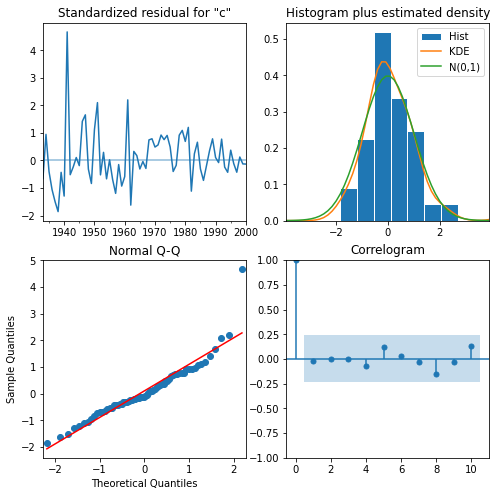

In [65]:
# Create the 4 diagostics plots
results_sarimax.plot_diagnostics(figsize=(8,8))
plt.show()

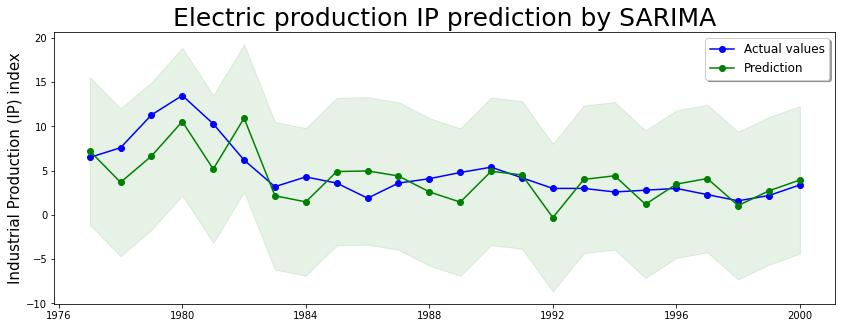

In [67]:
prediction = results_sarimax.get_prediction(start=-24)
mean_prediction=prediction.predicted_mean
mean_prediction = mean_prediction.rename("prediction")
confi_int_p=prediction.conf_int()
lower_limits_p=confi_int_p.iloc[:,0]
upper_limits_p=confi_int_p.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP prediction by SARIMA", fontsize=25)

plt.plot(train[-24:].index,train[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

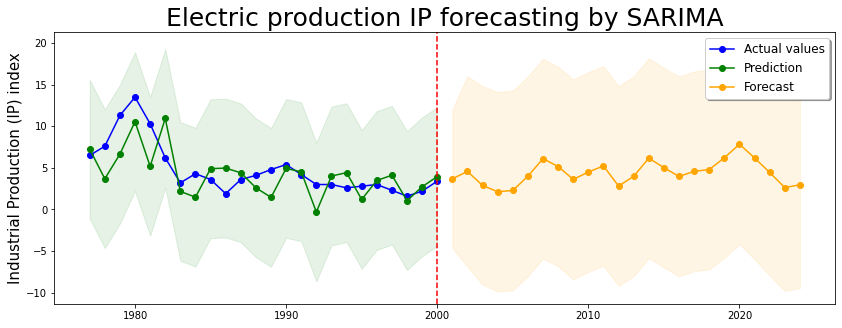

In [68]:
df_pred=train.iloc[-24:]
# Make ARIMA forecast of next 10 values
forecast = results_sarimax.get_forecast(steps=24)
mean_forecast=forecast.predicted_mean
mean_forecast = mean_forecast.rename("prediction")
confi_int_f=forecast.conf_int()
lower_limits_f=confi_int_f.iloc[:,0]
upper_limits_f=confi_int_f.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by SARIMA", fontsize=25)

plt.plot(train[-24:].index,train[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.plot(mean_forecast[-24:].index,mean_forecast[-24:].values, label='Forecast', color="orange", marker="o")
plt.fill_between(mean_forecast[-24:].index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(df_pred.iloc[-24:].index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [69]:
rmse_arima = sqrt(mean_squared_error(train[-24:].values,mean_prediction_arima.values))
print(f"RMSE OF SARIMA MODEL : {rmse_arima:.2f}")

RMSE OF SARIMA MODEL : 2.07


In [70]:
rmse_arima1 = sqrt(mean_squared_error(test[-24:].values,mean_forecast_arima.values))
print(f"RMSE OF SARIMA MODEL : {rmse_arima1:.2f}")

RMSE OF SARIMA MODEL : 2.85


In [71]:
rmse_sarima = sqrt(mean_squared_error(train[-24:].values,mean_prediction.values))
print(f"RMSE OF SARIMA MODEL : {rmse_sarima:.2f}")

RMSE OF SARIMA MODEL : 2.51


In [72]:
rmse_sarima1 = sqrt(mean_squared_error(test[-24:].values,mean_forecast.values))
print(f"RMSE OF SARIMA MODEL : {rmse_sarima1:.2f}")

RMSE OF SARIMA MODEL : 3.12


In [73]:
df_sarimax  = pd.concat([mean_prediction, mean_forecast])

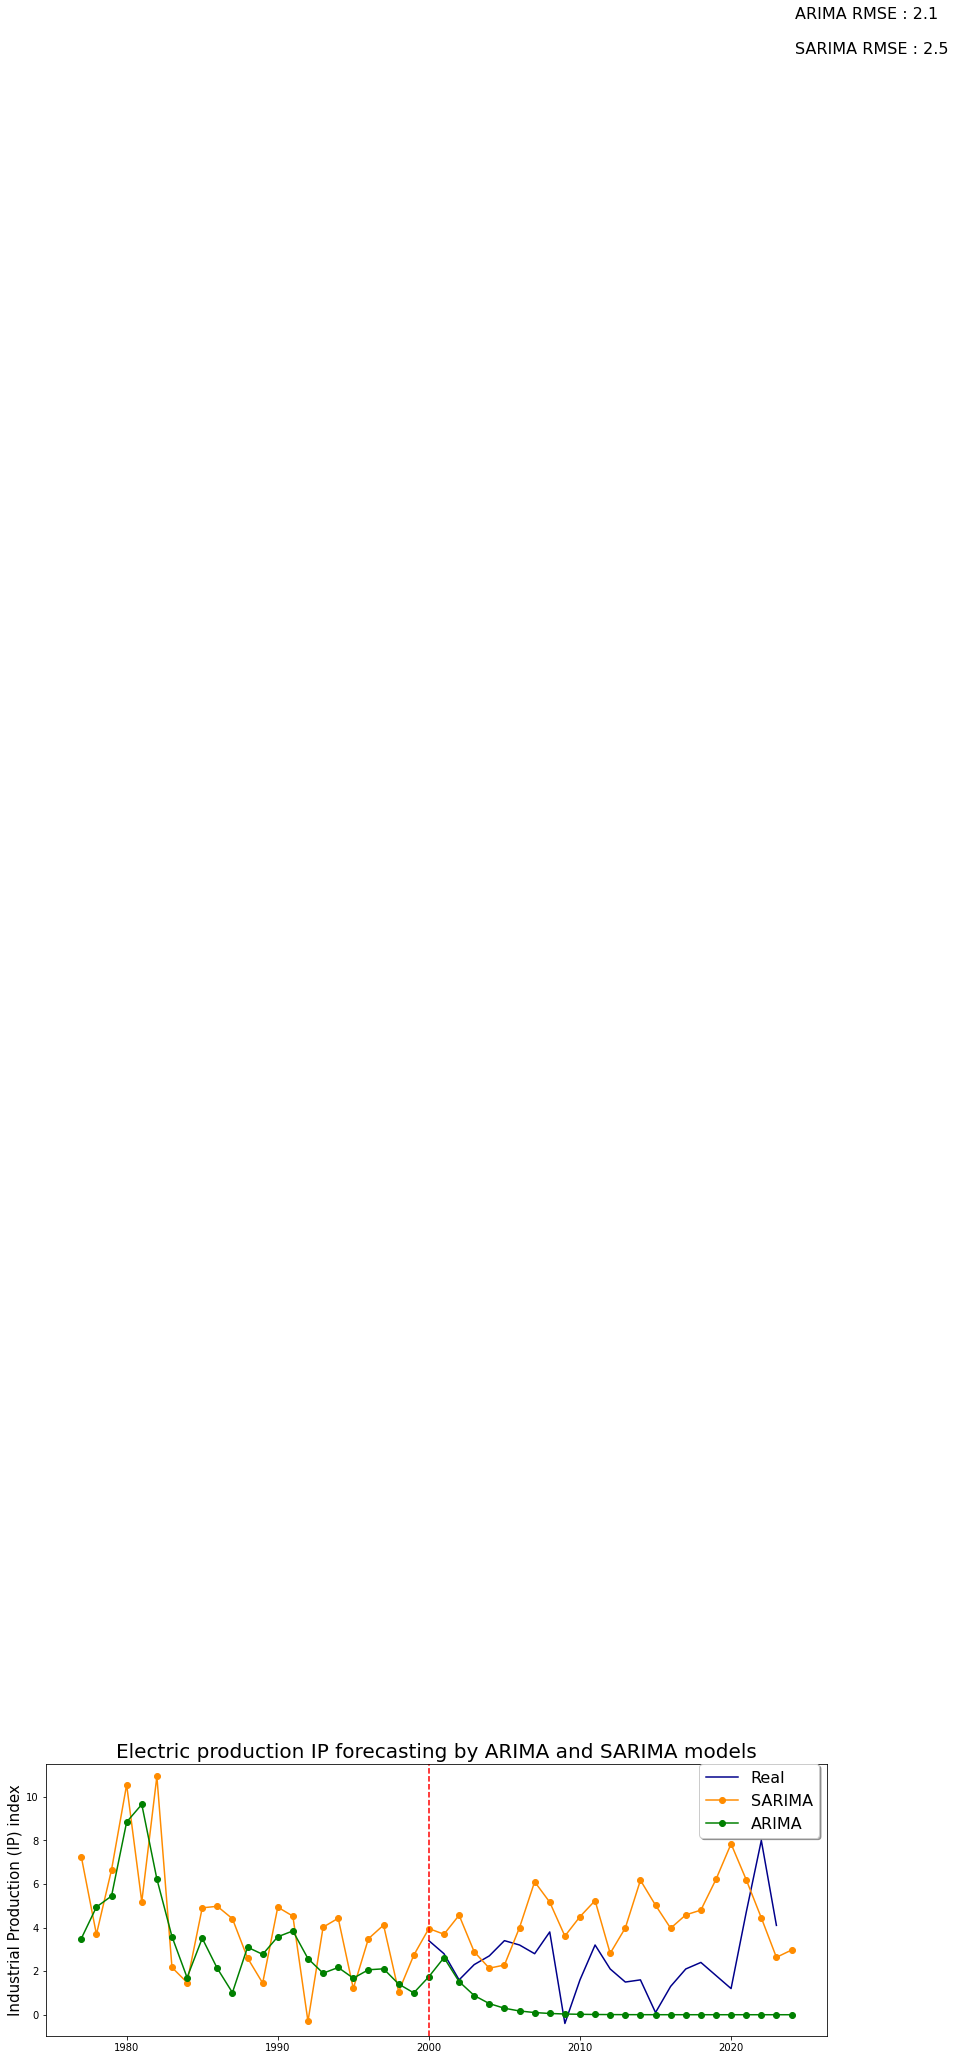

In [74]:
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by ARIMA and SARIMA models", fontsize=20)
plt.plot(test[-30:].index,test[-30:].values, color='darkblue', label='Real')
plt.plot(df_sarimax.index, df_sarimax.values, color='darkorange', label='SARIMA', marker='o')
plt.plot(df_arima.index, df_arima.values, color='green',label='ARIMA', marker='o')
plt.axvline(df_pred.index[-1], color="red", linestyle="--")
plt.legend(bbox_to_anchor=(1, 1.03),fontsize=16,fancybox=True, shadow=True, frameon=True)
text = 'ARIMA RMSE : {:.1f}\n\nSARIMA RMSE : {:.1f} '.format(rmse_arima,rmse_sarima)
plt.text(mean_forecast.index[-1] + pd.DateOffset(days=80),90,text, fontsize=16)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [160]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(df['value'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
new= model_fit.forecast(24)

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [162]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(df['value']),trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False)
print(model_fit.params)

new= model_fit.forecast(24)

{'smoothing_level': 0.5, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 68.39752666666662, 'initial_trend': -1.1764048484848448, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_19780\3650223120.py:3: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model_fit = model.fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False)


In [164]:
smooth = pd.DataFrame(new, columns=['Column_Name'])